# Übung 8: Generative adversarial networks

Generative adversarial networks (GANs) lernen implizit ein generatives Modell von einer gegebenen Datendistribution. Dies geschieht durch ein Nullsummenspiel zwischen zwei neuronalen Netzwerken: Ein Generatornetzwerk versucht eine Funktion zu lernen, die Zufallsdaten aus einer einfachen parametrischen Verteilung in Bilder überführt, die von dem zweiten Netzwerk, dem Diskriminator, nicht von echten Bildern zu unterscheiden sind. Der Diskriminator ist ein Classifier, der darauf trainiert wird, echte Bilder von solchen zu unterscheiden, die der Generator generiert.

In dieser Übung sollst du ein GAN für den MNIST Datensatz implementieren.

## MNIST

Laden den MNIST Datensatz und plotte ein paar der Datenpunkte als Bilder. Du kannst das Keras modul ```keras.datasets``` benutzen, um die Daten automatisch herunterzuladen und einzulesen.

In [ ]:
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("Hi Tim, vorrangig aus GPU-Gründen haben wir die Jan(n)is-Gruppe bei dieser Übung mit ins Boot geholt.")
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

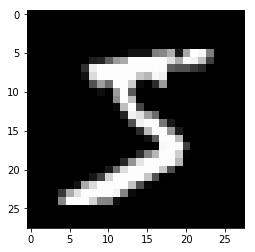

In [86]:
%matplotlib inline 
from keras.datasets import mnist
import matplotlib.pyplot as plt

(X_train, _), (_, _) = mnist.load_data()

plt.imshow(X_train[0], cmap=plt.cm.gray)

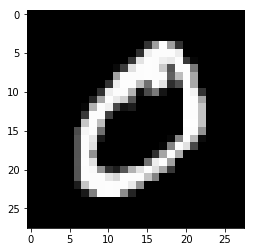

In [72]:
plt.imshow(X_train[1], cmap=plt.cm.gray)

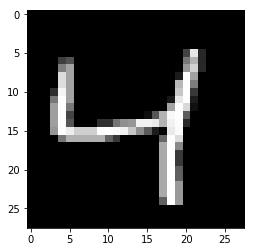

In [73]:
plt.imshow(X_train[2], cmap=plt.cm.gray)

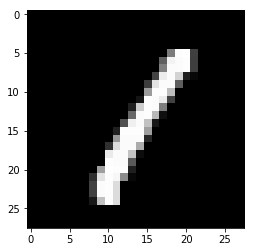

In [74]:
plt.imshow(X_train[3], cmap=plt.cm.gray)

## Generator

Erstelle nun zuerst ein Model, welches aus einem Tensor mit den Dimensionen ```[batch_size, z_dim]``` einen Tensor mit den Dimensionen ```[batch_size, 28, 28, 1]``` generiert. ```28x28``` ist hierbei die Bildgröße der MNIST Daten, die Größe des Noisevektors (```z_dim```) kannst du selbst wählen. 

Sample nun eine Batch von Zufallswerten, z.b. aus einer Normalverteilung, und erstelle mit dem untrainierten Generator ein Batch von Bildern. Plotte diese generierten Bilder.

In [75]:
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [76]:
def plot_imgs(generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

In [77]:
z_dim = 32
batch_size = 64
img_rows = 28
img_cols = 28
channels = 1
prob_drop_conv = 0.4
kernel_size = (5,5)
depth = 128

In [78]:
noise_shape = (z_dim,)
        
model = Sequential()

model.add(Dense(depth * 7 * 7, activation="relu", input_shape=noise_shape))
model.add(Reshape((7, 7, depth)))
model.add(BatchNormalization(momentum=0.8))
model.add(Dropout(prob_drop_conv))
model.add(UpSampling2D())

# ... add layers
model.add(Conv2DTranspose(int(depth/2), kernel_size, strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization(momentum=0.8))
model.add(UpSampling2D())

model.add(Conv2DTranspose(int(depth/4), kernel_size, strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization(momentum=0.8))

model.add(Conv2DTranspose(int(depth/8), kernel_size, strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization(momentum=0.8))

model.add(Conv2DTranspose(1, kernel_size, strides=(1, 1), padding='same', activation='tanh'))

noise = Input(shape=noise_shape)
img = model(noise)

generator = Model(noise, img)

In [79]:
noise = np.random.normal(0, 1, (batch_size, z_dim))

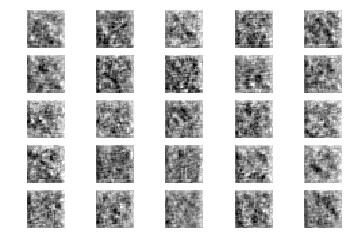

In [80]:
plot_imgs(generator)

## Discriminator

Erstelle nun ein Klassifizierungsnetzwerk, welchen mit dem Ausgabetensor des Generatornetzes (```[batch_size, 28, 28, 1]```) als Eingabe akzeptiert. Überprüfe, ob das Netzwerk die Ausgaben des Generators in Wahrscheinlichkeiten, also Werte zwischen 0 und 1, überführt.

In [81]:
img_shape = (img_rows, img_cols, channels)
        
model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.25))

#... add more layers
model.add(Flatten())

model.add(Dense(256))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.2))

model.add(Dense(1, activation='sigmoid'))

img = Input(shape=img_shape)
validity = model(img)

discriminator = Model(img, validity)

In [82]:
from keras.optimizers import RMSprop

opt = RMSprop(lr=0.0004, rho=0.9)

generator.compile(optimizer=opt, loss='binary_crossentropy')
discriminator.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

z = Input(shape=(32,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [83]:
discriminator.predict(generator.predict(noise))

array([[0.5023096 ],
       [0.50130105],
       [0.5009636 ],
       [0.5013481 ],
       [0.50271386],
       [0.50278443],
       [0.50149876],
       [0.5017336 ],
       [0.5027462 ],
       [0.5010684 ],
       [0.5012734 ],
       [0.50253564],
       [0.5014028 ],
       [0.5008106 ],
       [0.5016778 ],
       [0.5028935 ],
       [0.5026577 ],
       [0.5009108 ],
       [0.50075334],
       [0.5041284 ],
       [0.5007585 ],
       [0.50096977],
       [0.50075036],
       [0.50272113],
       [0.5023826 ],
       [0.5026194 ],
       [0.50320345],
       [0.50281197],
       [0.50248796],
       [0.5026295 ],
       [0.5024416 ],
       [0.5015958 ],
       [0.50318635],
       [0.5015381 ],
       [0.5034651 ],
       [0.50115216],
       [0.5010571 ],
       [0.5026848 ],
       [0.50110346],
       [0.5023901 ],
       [0.50477976],
       [0.5018815 ],
       [0.501703  ],
       [0.50251144],
       [0.50074977],
       [0.5012235 ],
       [0.5025503 ],
       [0.502

## Training
Implementiere das Training des GANs wie in der Vorlesung besprochen. Gebe während des Trainings den Generator-Loss und den Discriminator-Loss aus. Am Ende des Trainings zeige einige vom Generator generierte Bilder (**RESULT**).

In [87]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

In [88]:

#Erstelle batch_size/2 Indizes von echten Bildern:
random_indices = np.random.randint(0, X_train.shape[0], int(batch_size/2))
images = X_train[random_indices]
    
#Generiere batch_size/2 'falsche' Bilder:
noise = np.random.normal(0, 1, (int(batch_size/2), 32))
gen_images = generator.predict(noise)
#concat_imgs = np.concatenate((images, gen_images))

#Diskriminator trainieren
d_loss_real = discriminator.train_on_batch(images, np.ones([int(batch_size/2), 1]))
d_loss_fake = discriminator.train_on_batch(gen_images, np.zeros([int(batch_size/2), 1]))
d_loss = 0.5*np.add(d_loss_fake, d_loss_real)

c:\users\t\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [117]:
#So, und jetzt trainieren wir den Generator
epoch= 10

noise = np.random.normal(0, 1, (batch_size, 32))
valid_y = np.array([1]*batch_size)
c_loss = combined.train_on_batch(noise, valid_y)

print("Hi Tim, wir haben es (vermutlich) geschafft, das Ganze für einen Durchgang auszuführen, wissen aber nicht, wie genau wir das jetzt in eine Schleife packen sollten. Unten die Ergebnisse des einzigen Durchlaufs:")

print(epoch," Diskr.: ",d_loss[0],", Genauigkeit:",100*d_loss[1],", Komb.: ",c_loss)

Hi Tim, wir haben es (vermutlich) geschafft, das Ganze für einen Durchgang auszuführen, wissen aber nicht, wie genau wir das jetzt in eine Schleife packen sollten. Unten die Ergebnisse des einzigen Durchlaufs:
10  Diskr.:  0.40935606 , Genauigkeit: 50.0 , Komb.:  [0.019711673, 1.0]
